Read /Users/yfujii/work/COMET/data/cth_64_SC/test.merged.000.root

Start of a file
Event= 0
Event= 1
Event= 2
Event= 3
End of a file
Read /Users/yfujii/work/COMET/data/cth_64_SC/test.merged.001.root

Start of a file
Event= 0
Event= 1
Event= 2
Event= 3
End of a file
Read /Users/yfujii/work/COMET/data/cth_64_SC/test.merged.002.root

Start of a file
Event= 0
Event= 1
Event= 2
Event= 3
End of a file
Read /Users/yfujii/work/COMET/data/cth_64_SC/test.merged.003.root

Start of a file
Event= 0
Event= 1
Event= 2
Event= 3
End of a file
Read /Users/yfujii/work/COMET/data/cth_64_SC/test.merged.004.root

Start of a file
Event= 0
Event= 1
Event= 2
Event= 3
End of a file
Read /Users/yfujii/work/COMET/data/cth_64_SC/test.merged.005.root

Start of a file
Event= 0
Event= 1
Event= 2
Event= 3
End of a file
Read /Users/yfujii/work/COMET/data/cth_64_SC/test.merged.006.root

Start of a file
Event= 0
Event= 1
Event= 2
Event= 3
End of a file
Read /Users/yfujii/work/COMET/data/cth_64_SC/test.merged.007.root

St

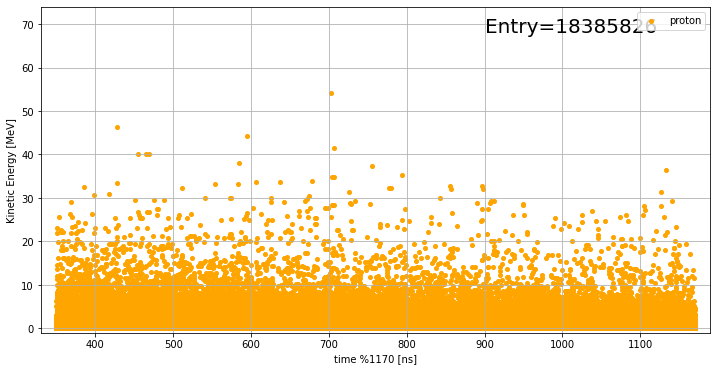

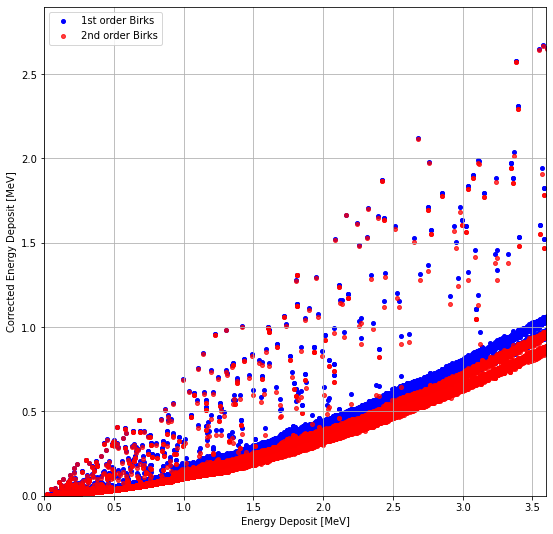

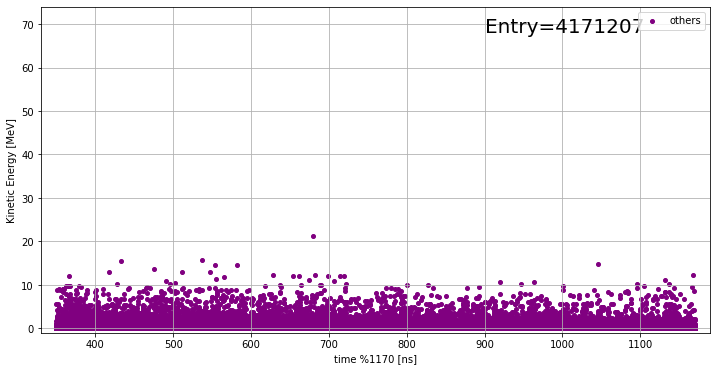

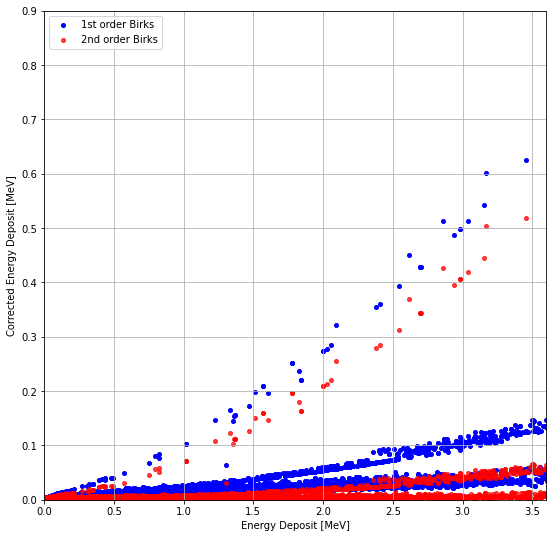

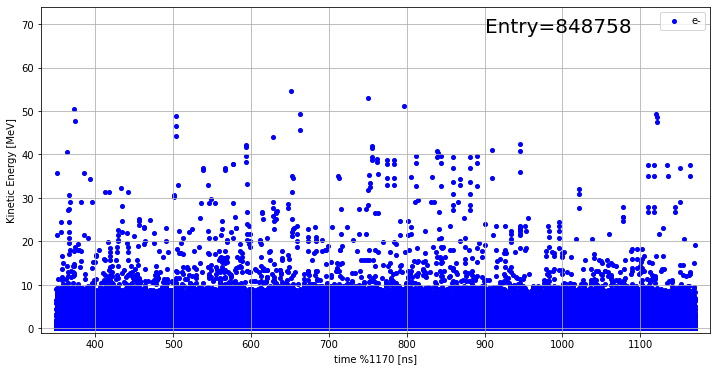

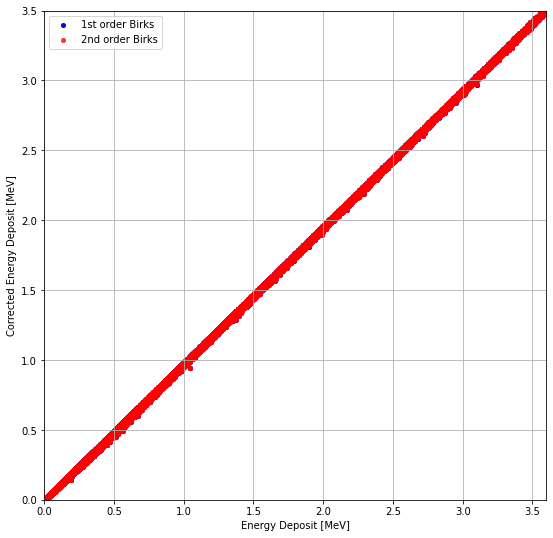

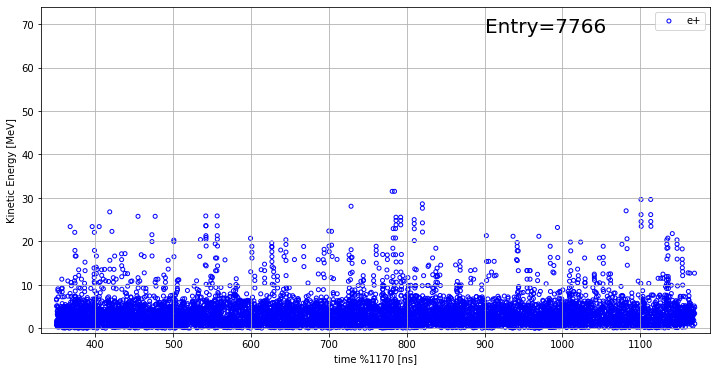

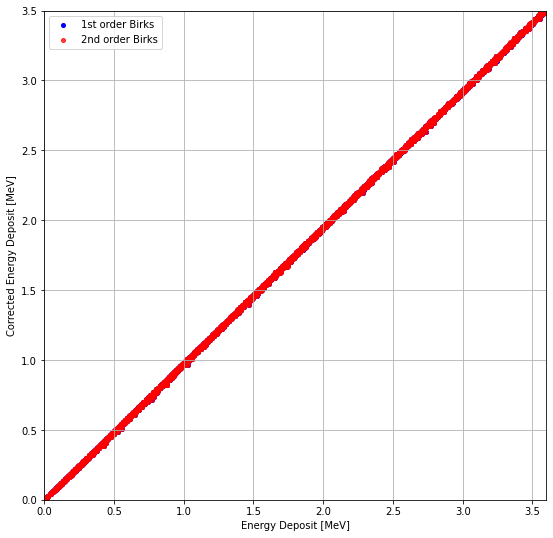

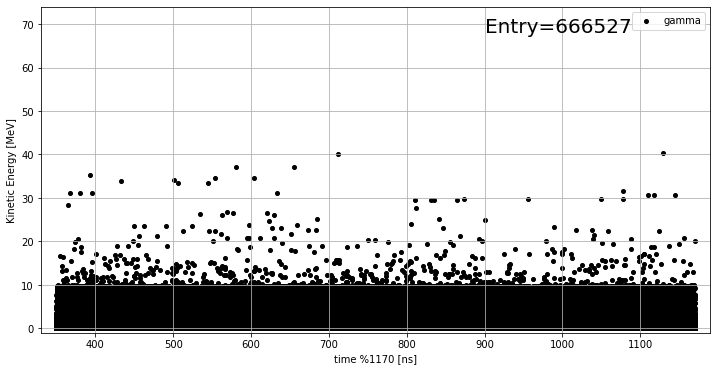

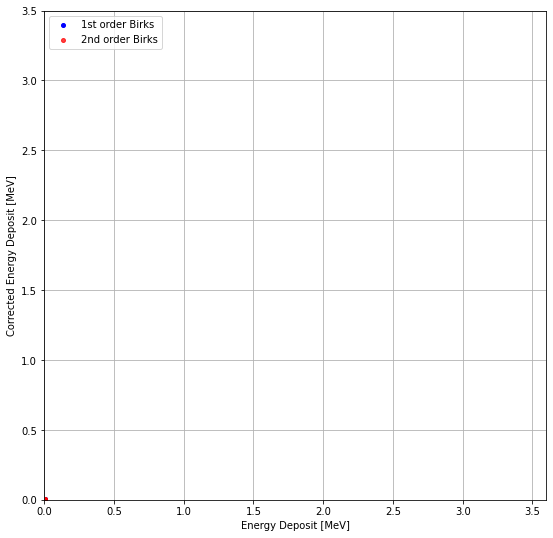

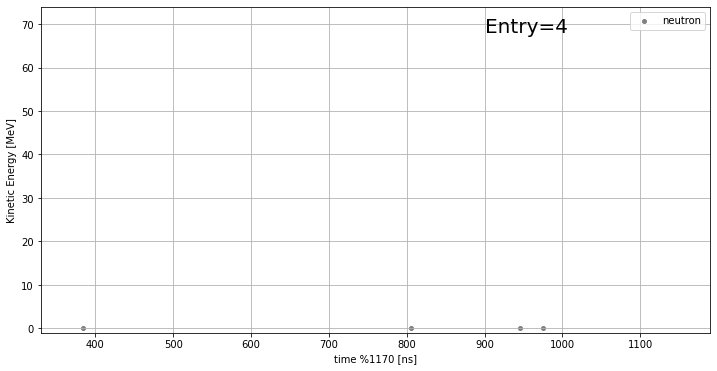

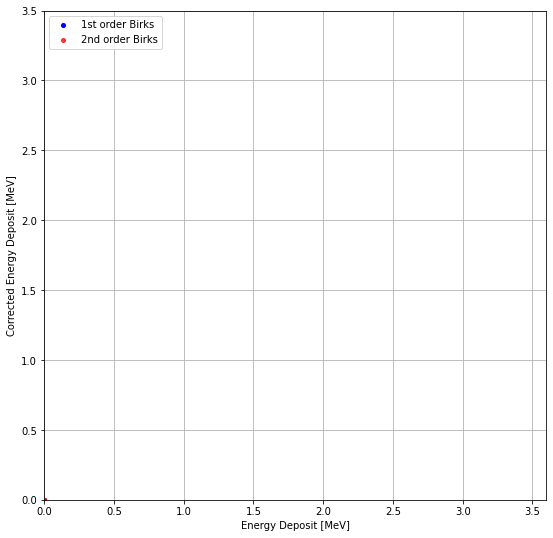

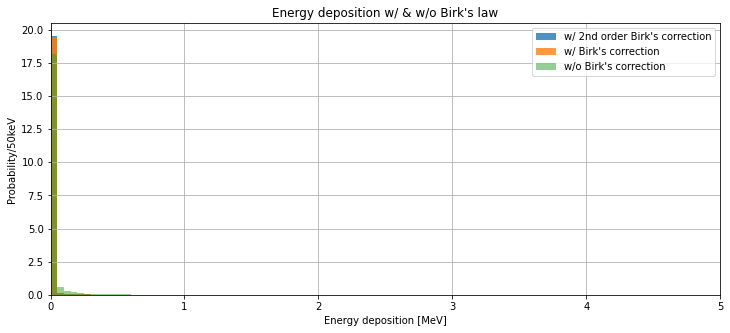

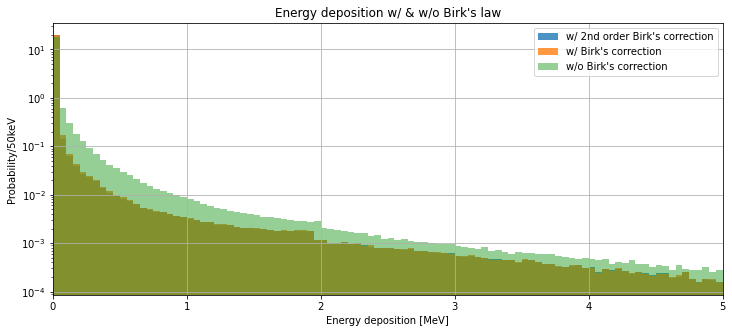

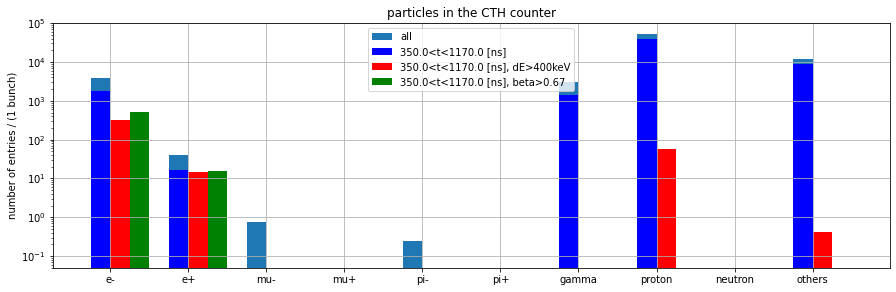

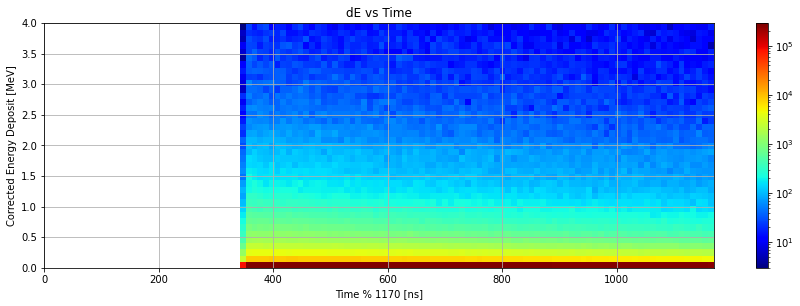

In [2]:
import uproot

import math

import numpy as np

import matplotlib.pyplot as plt

from matplotlib.colors import LogNorm

from scipy import stats

#kBirks=0.125 # [mm/MeV] Assuming density = 1g/cm^3, https://en.wikipedia.org/wiki/Birks%27_law
################################
# http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.461.2481&rep=rep1&type=pdf
# for NE-102
################################
kBirks=0.130
kBirks2=[0.129,9.59e-4] # [mm/MeV] and [mm/MeV]^2


fMassN=939.5654 # mass of neutron
fMassP=938.2721 # mass of proton

ielectron=0
ipositron=1
imuminus=2
imuplus=3
ipiminus=4
ipiplus=5
igamma=6
iproton=7
ineutron=8
iothers=9
names=["e-","e+","mu-","mu+","pi-","pi+","gamma","proton","neutron","others"]
values=[0,0,0,0,0,0,0,0,0,0]
values1=[0,0,0,0,0,0,0,0,0,0] # only t cut
values2=[0,0,0,0,0,0,0,0,0,0] # with t & e cut
values3=[0,0,0,0,0,0,0,0,0,0] # with t & b cut

### Rough selection
#window=[250.0,1150.0]
window=[350.0,1170.0]
ethreshold=0.40
bthreshold=0.67

def get_nmass(pdgCode):
    AAA = (pdgCode% 10000) / 10
    ZZZ = (pdgCode/10000)% 1000
    return (fMassP*float(ZZZ)+fMassN*float(AAA-ZZZ))


def particle_selection(pid,time,edep,beta,values,values1,values2,values3):
    index=0
    if (pid==11):
        index=0
    elif (pid==-11):
        index=1
    elif (pid==13):
        index=2
    elif (pid==-13):
        index=3
    elif (pid==-211):
        index=4
    elif (pid==211):
        index=5
    elif (pid==22):
        index=6
    elif (pid==2212):
        index=7
    elif (pid==2112):
        index=8
    else:
        index=9

    values[index]=values[index]+1
    if (time>window[0] and time<=window[1]): values1[index]=values1[index]+1
    if (time>window[0] and time<=window[1] and edep>ethreshold): values2[index]=values2[index]+1
    if (time>window[0] and time<=window[1] and beta>bthreshold): values3[index]=values3[index]+1
    return index
    

def process(events,values,value1,values2,values3,
            tmod,edep_all,edep_corr,edep_corr2,beta_all,momA,ekin,onlyDelayed,draw):
    print("")
    print("Start of a file")    
    #nevents=events.numentries
    nevents=0
    for data in events.iterate(["eventId","cth_*"],entrysteps=1,namedecode="utf-8"):
        eventId=int(data["eventId"])
        if(eventId==4):continue # For this dataset
        nevents=nevents+1
        print("Event=",eventId)
        nhits=int(data["cth_nHits"])
        cth_edep=data["cth_edep"]
        cth_stepL=data["cth_stepL"]
        cth_pdgId=data["cth_pdgId"]
        cth_time=data["cth_t"]
        cth_x,cth_y,cth_z=data["cth_x"],data["cth_y"],data["cth_z"]
        cth_px,cth_py,cth_pz=data["cth_px"],data["cth_py"],data["cth_pz"]
        cth_beta=data["cth_beta"]
        cth_segId=data["cth_segId"]
        cth_hodId=data["cth_hodId"] # 0/1 Up/downstream
        cth_cryId=data["cth_cryType"] # 0: Cherenkov, 1: Scintillator, 10: CherenLG, 11: ScintLG
        ##### Birks' law
        dEdx=data["cth_edep"]/data["cth_stepL"]
        cth_edep_corr=(data["cth_edep"]/(1.0+kBirks*dEdx))
        cth_edep_corr2=(data["cth_edep"]/(1.0+kBirks2[0]*dEdx+kBirks2[1]*dEdx*dEdx))
        edep=[]
        time=[]
        data2D1=[]
        data2D2=[]
        for ihit in range(nhits):
            if cth_cryId[0][ihit]==11:continue ## Skip if this is a scintillator's light guide
            if cth_edep[0][ihit]<2e-6:continue ## Skip the hit with edep < 2eV
            
            tmod_loc=math.fmod(cth_time[0][ihit],1170.0)
            
            pidx=particle_selection(int(cth_pdgId[0][ihit]),tmod_loc,cth_edep_corr[0][ihit],cth_beta[0][ihit],
                                    values,values1,values2,values3)
            
            if onlyDelayed==True and tmod_loc<window[0]: continue ## Skip prompt hit

            if(draw==True):
                edep.append(cth_edep[0][ihit])
                time.append(cth_time[0][ihit])

            mom=math.sqrt(cth_px[0][ihit]*cth_px[0][ihit]+
                          cth_py[0][ihit]*cth_py[0][ihit]+
                          cth_pz[0][ihit]*cth_pz[0][ihit])
            beta=cth_beta[0][ihit]
            tmod[pidx].append(tmod_loc)
            edep_all[pidx].append(cth_edep[0][ihit])
            edep_corr[pidx].append(cth_edep_corr[0][ihit])
            edep_corr2[pidx].append(cth_edep_corr2[0][ihit])
            beta_all[pidx].append(beta)
            
            momA[pidx].append(mom)
            ##### Regain the kinetic energy from momentum and beta
            if(beta>0):
                ekin[pidx].append(mom/beta*(1.0-math.sqrt(1.0-beta*beta)))
            else:
                if(cth_pdgId[0][ihit]>1000000000):
                    nmass=get_nmass(cth_pdgId[0][ihit])
                    ekin[pidx].append(math.sqrt(mom*mom+nmass*nmass)-nmass)
                elif(cth_pdgId[0][ihit]==2112):
                    ekin[pidx].append(math.sqrt(mom*mom+fMassN*fMassN)-fMassN)
                else:
                    ekin[pidx].append(mom)# Not true for all `others`
                
        if (draw==True):
            ###### Draw 2D
            plt.figure(figsize=(15.0, 4.5))
            plt.grid(True)
            plt.ylabel('Energy deposition [MeV]')
            plt.xlabel('Time [ns]')
            x_bins = np.linspace(0,3600,90)
            y_bins = np.linspace(0,4,40)
            plt.hist2d(time,edep,bins=[x_bins,y_bins],cmap=plt.cm.jet,norm=LogNorm())
            plt.xlim(0, 3600)
            plt.ylim(0.0, 4.0)
            plt.colorbar()
            # Add contour
            #xy = np.vstack([time,edep])
            #z = stats.gaussian_kde(xy)(xy)
            #plt.scatter(time,edep,c=z,s=24,edgecolor='')                                                                           
            plt.show()
            ###### Draw 1D
            plt.figure(figsize=(15.0, 4.5))
            plt.hist(time,density=False, bins=180, range=(0,3600))
            plt.ylabel('Entries/20ns')
            plt.xlabel('Time [ns]')
            plt.xlim(0,3600)
            plt.show()
    print("End of a file")
    return nevents

#########
#dataDir="/Users/yfujii/work/COMET/data/21Apr/"
#dataDir="/Users/yfujii/work/COMET/data/cth_64_SS/"
#dataDir="/Users/yfujii/work/COMET/data/cth_48/"
dataDir="/Users/yfujii/work/COMET/data/cth_64_SC/"


#nInputFiles=62
nInputFiles=60
fileList=[]
for i in range(nInputFiles):
    num=str(i)
    #print(dataDir+"test.merged."+num.zfill(3)+".root")
    fileList.append(dataDir+"test.merged."+num.zfill(3)+".root")

tmod=[[],[],[],[],
      [],[],[],[],
      [],[],[]]
edep=[[],[],[],[],
      [],[],[],[],
      [],[],[]]
edep_corr=[[],[],[],[],
           [],[],[],[],
           [],[],[]]
edep_corr2=[[],[],[],[],
            [],[],[],[],
            [],[],[]]
beta=[[],[],[],[],
      [],[],[],[],
      [],[],[]]
momA=[[],[],[],[],
      [],[],[],[],
      [],[],[]]
ekin=[[],[],[],[],
      [],[],[],[],
      [],[],[]]
pot_per_bunch=16e6
tot_pot=0.0
tot_bunch=0.0
for ifile in range(len(fileList)):
    print("Read",fileList[ifile])
    events  = uproot.open(fileList[ifile])["mc"]
    nevents = process(events,values,values1,values2,values3,
                      tmod,edep,edep_corr,edep_corr2,beta,momA,ekin,True,False)
                      
    tot_pot = tot_pot + pot_per_bunch * float(2 * nevents)
    tot_bunch = tot_bunch + float(2*nevents)

ecolour=['blue','blue','green','green','red','red',
         'black','orange','gray','purple']
fcolour=['blue','none','green','none','red','none',
         'black','orange','gray','purple']


newIdx=[iproton,iothers,ielectron,imuminus,ipositron,
        imuplus,ipiminus,ipiplus,igamma,ineutron]
#plt.figure(figsize=(12.0,6.0))
#plt.xlim(200,1200)
#plt.ylim(-1,150)
for j in range(len(names)):
    #values[j] = values[j]/tot_pot
    values[j]  = values[j]/tot_bunch
    values1[j] = values1[j]/tot_bunch
    values2[j] = values2[j]/tot_bunch
    values3[j] = values3[j]/tot_bunch
    jj=newIdx[j]
    if len(tmod[jj])>0:
        plt.figure(figsize=(12.0,6.0))
        plt.xlim(window[0]-20,window[1]+20)
        plt.ylim(-1,74)
        plt.grid(True)
        plt.text(900, 68, size=20, s='Entry='+str(len(tmod[jj])))
        plt.xlabel('time %1170 [ns]')
        #plt.ylabel('Momentum [MeV/c]')
        #plt.scatter(tmod[jj],momA[jj],facecolors=fcolour[jj], edgecolors=ecolour[jj], label=names[jj], s=22)
        plt.ylabel('Kinetic Energy [MeV]')
        plt.scatter(tmod[jj],ekin[jj],facecolors=fcolour[jj], edgecolors=ecolour[jj], label=names[jj], s=16)
        plt.legend(loc='upper right')
        plt.show()
        #### Birks correction
        plt.figure(figsize=(9.0,9.0))
        ymax=3.5
        if(names[jj]=='proton'):ymax=2.9
        if(names[jj]=='others'):ymax=0.9
        plt.xlim(0,3.6)
        plt.ylim(0,ymax)
        plt.grid(True)
        plt.xlabel('Energy Deposit [MeV]')
        plt.ylabel('Corrected Energy Deposit [MeV]')
        plt.scatter(edep[jj],edep_corr[jj], facecolors='blue', edgecolors='blue', label='1st order Birks', s=16)
        plt.scatter(edep[jj],edep_corr2[jj],facecolors='red',  edgecolors='red',  label='2nd order Birks', s=16, alpha=0.75)
        plt.legend(loc='upper left')
        plt.show()



tmod_all=[]
edep_all=[]
edep_corr_all=[]
edep_corr_all2=[]
for j in range(len(names)):
    tmod_all=tmod_all+tmod[j]
    edep_all=edep_all+edep[j]
    edep_corr_all=edep_corr_all+edep_corr[j]
    edep_corr_all2=edep_corr_all2+edep_corr2[j]

plt.figure(figsize=(12.0, 5))
plt.hist(edep_corr_all2,density=True,bins=100,range=(0,5),alpha=0.8,label="w/ 2nd order Birk's correction")
plt.hist(edep_corr_all,density=True,bins=100,range=(0,5),alpha=0.8,label="w/ Birk's correction")
plt.hist(edep_all,density=True,bins=100,range=(0,5),alpha=0.5,label="w/o Birk's correction")
plt.grid(True)
plt.xlim(0,5)
plt.title("Energy deposition w/ & w/o Birk's law")
plt.xlabel('Energy deposition [MeV]')
plt.ylabel('Probability/50keV')
plt.legend(loc='upper right')
plt.show()
plt.figure(figsize=(12.0, 5))
plt.hist(edep_corr_all2,density=True,bins=100,range=(0,5),alpha=0.8,label="w/ 2nd order Birk's correction")
plt.hist(edep_corr_all,density=True,bins=100,range=(0,5),alpha=0.8,label="w/ Birk's correction")
plt.hist(edep_all,density=True,bins=100,range=(0,5),alpha=0.5,label="w/o Birk's correction")
plt.grid(True)
plt.xlim(0,5)
plt.title("Energy deposition w/ & w/o Birk's law")
plt.xlabel('Energy deposition [MeV]')
plt.ylabel('Probability/50keV')
plt.legend(loc='upper right')
plt.yscale('log')
plt.show()

plt.figure(figsize=(15.0, 4.5))
left = np.arange(len(names))
width= 0.25
plt.bar(left,        values ,width=width,label='all')
label=str(window[0])+'<t<'+str(window[1])+' [ns]'
plt.bar(left,        values1,width=width,color='blue', label=label)
label=str(window[0])+'<t<'+str(window[1])+' [ns], dE>400keV'
plt.bar(left+width,  values2,width=width,color='red',  label=label)
label=str(window[0])+'<t<'+str(window[1])+' [ns], beta>0.67'
plt.bar(left+2*width,values3,width=width,color='green',label=label)
plt.xticks(left+width/2, names)
plt.grid(True)
plt.ylabel('number of entries / (1 bunch)')
plt.ylim(5e-2,1e5)
plt.yscale('log')
plt.title("particles in the CTH counter")
plt.legend(loc='upper center')
plt.show()

###### Draw 2D
plt.figure(figsize=(15.0, 4.5))
plt.ylabel('Energy deposition [MeV]')
plt.xlabel('Time [ns]')
x_bins = np.linspace(0,1170,117)
y_bins = np.linspace(0,4,40)
plt.hist2d(tmod_all,edep_all,bins=[x_bins,y_bins],cmap=plt.cm.jet,norm=LogNorm())
plt.grid(True)
plt.xlim(0, 1170)
plt.ylim(0.0, 4.0)
plt.colorbar()
plt.ylabel('Corrected Energy Deposit [MeV]')
plt.xlabel('Time % 1170 [ns]')
plt.title('dE vs Time')
# Add contour
#xy = np.vstack([time,edep])
#z = stats.gaussian_kde(xy)(xy)
#plt.scatter(time,edep,c=z,s=24,edgecolor='')                                                                           
plt.show()

#plt.figure(figsize=(15.0, 4.5))
#plt.ylabel('Energy deposition [MeV]')
#plt.xlabel('Time [ns]')
#x_bins = np.linspace(0,1170,117)
#y_bins = np.linspace(0,1,40)
#plt.hist2d(tmod,beta,bins=[x_bins,y_bins],cmap=plt.cm.jet,norm=LogNorm())
#plt.grid(True)
#plt.xlim(0, 1170)
#plt.ylim(0.0, 1.0)
#plt.colorbar()
#plt.ylabel('Beta')
#plt.xlabel('Time % 1170 [ns]')
#plt.title('Beta vs Time')                                                                       
#plt.show()